# FloyHub introduction to Deep Learning: Transfer Learning

### Abstract

Imagine you have a Computer Vision Task and a small dataset, what can you do? Take a model trained on a bigger dataset like ImageNet, fine-tune the last layer[s], try some optimizationg strategy & Hyperparameters choice and learn the new task. This is the main reason behind the mainstream adoption of Transfer Learning: transfer the 'knowledge' acquired on a big dataset freezing the layer which does the features extraction and learn the new task.

## Introduction

NIPS 2016 Andrew Ng about Trasfer Learning is driving DL success
![Transfer Learning is driving DL adoptions](http://ruder.io/content/images/2017/03/andrew_ng_drivers_ml_success-1.png)

Do not waste your time at building new model from scratch, use exsiting knowledge (Transfer Laerning in real-life :))
![do not be a hero -karphaty]()

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


# Seed for replicability
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)

plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/dogsvscats'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

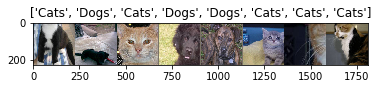

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Metrics to plot
    train_loss = []
    train_accu = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # Loss Metric
                train_loss.append(loss.cpu().data[0])

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Accuracy Metric
                prediction = outputs.cpu().data.max(1)[1]   # first column has actual prob.
                accuracy = prediction.eq(labels.cpu().data).sum()/8*100
                train_accu.append(accuracy)
                
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_accu

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [8]:
model = models.resnet18(pretrained=True)

# Fine Tuning - train only the last FC layer
# for param in model.parameters():
#     param.requires_grad = False
    
# Set class output
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion.cuda()
# Observe that all parameters are being optimized 
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
#optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

It should take X on CPU and 13-15' GPU 

In [9]:
model, train_loss, train_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1381 Acc: 0.7907
val Loss: 0.0572 Acc: 0.9055

Epoch 1/24
----------
train Loss: 0.1484 Acc: 0.7817
val Loss: 0.0587 Acc: 0.8905

Epoch 2/24
----------
train Loss: 0.1170 Acc: 0.8117
val Loss: 0.0393 Acc: 0.9328

Epoch 3/24
----------
train Loss: 0.1271 Acc: 0.8067
val Loss: 0.0188 Acc: 0.9602

Epoch 4/24
----------
train Loss: 0.0885 Acc: 0.8506
val Loss: 0.0222 Acc: 0.9751

Epoch 5/24
----------
train Loss: 0.0747 Acc: 0.8701
val Loss: 0.0198 Acc: 0.9627

Epoch 6/24
----------
train Loss: 0.0674 Acc: 0.8906
val Loss: 0.0176 Acc: 0.9726

Epoch 7/24
----------
train Loss: 0.0524 Acc: 0.9146
val Loss: 0.0162 Acc: 0.9801

Epoch 8/24
----------
train Loss: 0.0461 Acc: 0.9211
val Loss: 0.0109 Acc: 0.9826

Epoch 9/24
----------
train Loss: 0.0477 Acc: 0.9171
val Loss: 0.0123 Acc: 0.9851

Epoch 10/24
----------
train Loss: 0.0435 Acc: 0.9296
val Loss: 0.0094 Acc: 0.9876

Epoch 11/24
----------
train Loss: 0.0455 Acc: 0.9201
val Loss: 0.0103 Acc: 0.9925

Ep

NameError: name 'train_loss' is not defined

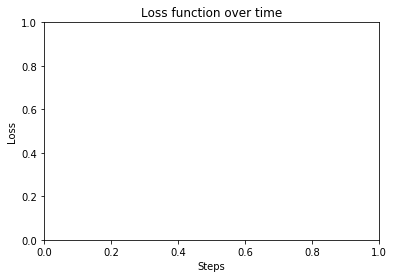

In [18]:
# Plot Loss
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

NameError: name 'train_accu' is not defined

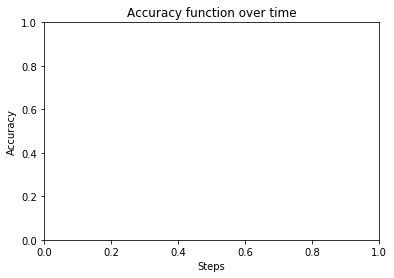

In [19]:
# Plot Acc
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_acc)), train_acc)

## ConvNet as fixed feature extractor

In [8]:
model = models.resnet18(pretrained=True)

# Fine Tuning - train only the last FC layer
for param in model.parameters():
    param.requires_grad = False
    
# Set class output
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion.cuda()
# Observe that all parameters are being optimized 
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.0001)
#optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 66080310.35it/s]


It should take X on CPU and 4-5' GPU 

In [9]:
model, train_loss, train_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0890 Acc: 0.5674
val Loss: 0.0695 Acc: 0.7637

Epoch 1/24
----------
train Loss: 0.0735 Acc: 0.7103
val Loss: 0.0557 Acc: 0.8507

Epoch 2/24
----------
train Loss: 0.0662 Acc: 0.7702
val Loss: 0.0485 Acc: 0.8930

Epoch 3/24
----------
train Loss: 0.0613 Acc: 0.7987
val Loss: 0.0426 Acc: 0.9129

Epoch 4/24
----------
train Loss: 0.0552 Acc: 0.8397
val Loss: 0.0383 Acc: 0.9229

Epoch 5/24
----------
train Loss: 0.0523 Acc: 0.8467
val Loss: 0.0343 Acc: 0.9229

Epoch 6/24
----------
train Loss: 0.0503 Acc: 0.8646
val Loss: 0.0305 Acc: 0.9328

Epoch 7/24
----------
train Loss: 0.0489 Acc: 0.8457
val Loss: 0.0304 Acc: 0.9453

Epoch 8/24
----------
train Loss: 0.0484 Acc: 0.8541
val Loss: 0.0307 Acc: 0.9378

Epoch 9/24
----------
train Loss: 0.0495 Acc: 0.8437
val Loss: 0.0302 Acc: 0.9353

Epoch 10/24
----------
train Loss: 0.0488 Acc: 0.8437
val Loss: 0.0295 Acc: 0.9328

Epoch 11/24
----------
train Loss: 0.0480 Acc: 0.8546
val Loss: 0.0298 Acc: 0.9303

Ep

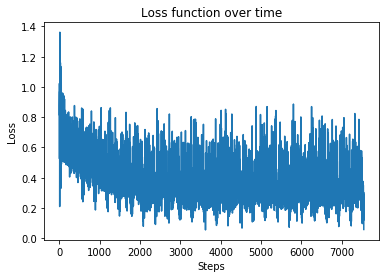

In [10]:
# Plot Loss
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

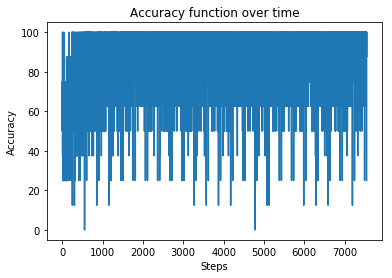

In [11]:
# Plot Acc
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_acc)), train_acc)